<a href="https://colab.research.google.com/github/Deshik18/Federated-Learning-using-GRU-and-Transformers/blob/main/Federated%20Learning%20using%20GRU%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark torch pysyft pandas


In [ ]:
!pip install syft

In [3]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv")

In [4]:
data

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836
...,...,...
22690,2014-02-19 15:05:00,98.185415
22691,2014-02-19 15:10:00,97.804168
22692,2014-02-19 15:15:00,97.135468
22693,2014-02-19 15:20:00,98.056852


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import copy

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Use the last GRU output
        return out

# Load data from CSV files
def load_data_from_folder(folder_path, seq_length=12):
    data = []
    targets = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))
            values = df["value"].values
            # Normalize the values
            values = (values - np.mean(values)) / np.std(values)
            # Convert time series into sequences
            for i in range(len(values) - seq_length):
                data.append(values[i:i+seq_length])
                targets.append(values[i+seq_length])  # Predict the next value
    data = np.array(data)
    targets = np.array(targets)
    return torch.tensor(data, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Federated Averaging
def federated_avg(models):
    global_model = copy.deepcopy(models[0])
    with torch.no_grad():
        for key in global_model.state_dict().keys():
            model_states = [model.state_dict()[key] for model in models]
            stacked_states = torch.stack(model_states, dim=0)
            global_model.state_dict()[key].copy_(stacked_states.mean(dim=0))
    return global_model

# Training loop for local models
def train_local_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-1))  # Add channel dimension
            loss = criterion(outputs.squeeze(), targets)  # Match dimensions
            loss.backward()
            optimizer.step()
    return model

# Global settings
input_size = 1
hidden_size = 64
output_size = 1
seq_length = 12
learning_rate = 0.01
local_epochs = 5
global_epochs = 10
batch_size = 32
clients = ["AWS", "Ads", "Traffic", "Tweets"]

# Load data for each client
client_data = {}
for client in clients:
    folder_path = f"/content/{client}"
    client_data[client] = load_data_from_folder(folder_path, seq_length)

# Train federated model
global_model = GRUModel(input_size, hidden_size, output_size)
for global_epoch in range(global_epochs):
    local_models = []

    # Train each client locally
    for client, (client_data_inputs, client_data_targets) in client_data.items():
        dataloader = DataLoader(
            TensorDataset(client_data_inputs, client_data_targets),
            batch_size=batch_size, shuffle=True
        )
        local_model = copy.deepcopy(global_model)
        optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        trained_model = train_local_model(
            model=local_model,
            dataloader=dataloader,
            criterion=criterion,
            optimizer=optimizer,
            epochs=local_epochs
        )
        local_models.append(trained_model)

    # Federated averaging
    global_model = federated_avg(local_models)

    print(f"Global Epoch {global_epoch + 1}/{global_epochs} complete.")

print("Federated training complete!")


Global Epoch 1/10 complete.
Global Epoch 2/10 complete.
Global Epoch 3/10 complete.
Global Epoch 4/10 complete.
Global Epoch 5/10 complete.
Global Epoch 6/10 complete.
Global Epoch 7/10 complete.
Global Epoch 8/10 complete.
Global Epoch 9/10 complete.
Global Epoch 10/10 complete.
Federated training complete!


In [9]:
torch.save(global_model.state_dict(), "global_model.pth")

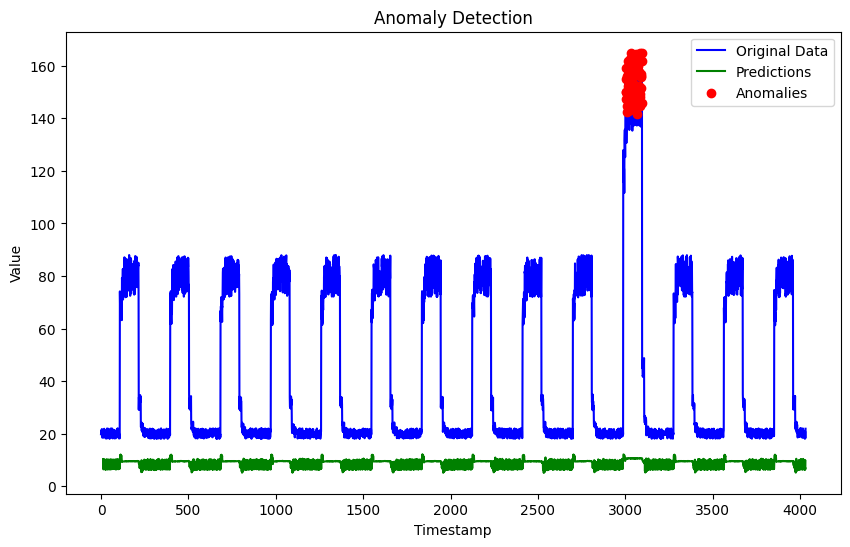

In [12]:
import matplotlib.pyplot as plt

# Function to test the global model and plot anomalies
def test_and_plot_anomalies(global_model, csv_file, seq_length=12):
    # Load data
    df = pd.read_csv(csv_file)
    values = df["value"].values
    data = [values[i:i + seq_length] for i in range(len(values) - seq_length)]
    data = np.array(data).reshape(-1, seq_length, 1)  # Reshape to [batch_size, seq_length, input_size]
    data = torch.tensor(data, dtype=torch.float32)

    # Predict
    global_model.eval()
    with torch.no_grad():
        predictions = []
        for sequence in data:
            sequence = sequence.unsqueeze(0)  # Add batch dimension if not already added
            prediction = global_model(sequence)
            predictions.append(prediction.item())

    # Calculate errors
    errors = np.abs(values[seq_length:] - np.array(predictions))
    threshold = errors.mean() + 3 * errors.std()
    anomalies = errors > threshold

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(values)), values, label="Original Data", color="blue")
    plt.plot(range(seq_length, len(values)), predictions, label="Predictions", color="green")
    plt.scatter(
        np.arange(seq_length, len(values))[anomalies],
        values[seq_length:][anomalies],
        color="red",
        label="Anomalies",
        zorder=5
    )
    plt.title("Anomaly Detection")
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Test the global model
test_csv_file = "art_daily_jumpsup.csv"
test_and_plot_anomalies(global_model, test_csv_file)


In [ ]:
def add_new_client(global_model, client_folder_path, seq_length=12, local_epochs=5, batch_size=32):
    """
    Adds a new client's data to the global model.

    Args:
        global_model: The current global model.
        client_folder_path: Path to the folder containing the new client's CSV data.
        seq_length: Sequence length for time-series data.
        local_epochs: Number of epochs to train locally for the new client.
        batch_size: Batch size for training.

    Returns:
        Updated global model after including the new client's data.
    """
    # Load new client data
    client_data_inputs, client_data_targets = load_data_from_folder(client_folder_path, seq_length)
    dataloader = DataLoader(TensorDataset(client_data_inputs, client_data_targets),
                            batch_size=batch_size, shuffle=True)

    # Train a local model on the new client's data
    local_model = copy.deepcopy(global_model)
    optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    trained_model = train_local_model(
        model=local_model,
        dataloader=dataloader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=local_epochs
    )

    # Federated averaging: Integrate the new local model into the global model
    updated_global_model = federated_avg([global_model, trained_model])
    return updated_global_model

# Example usage:
# global_model = add_new_client(global_model, "/content/NewClient", seq_length=12)
